# Pizza Runner

In [2]:
from IPython.display import Image

# ER Diagram

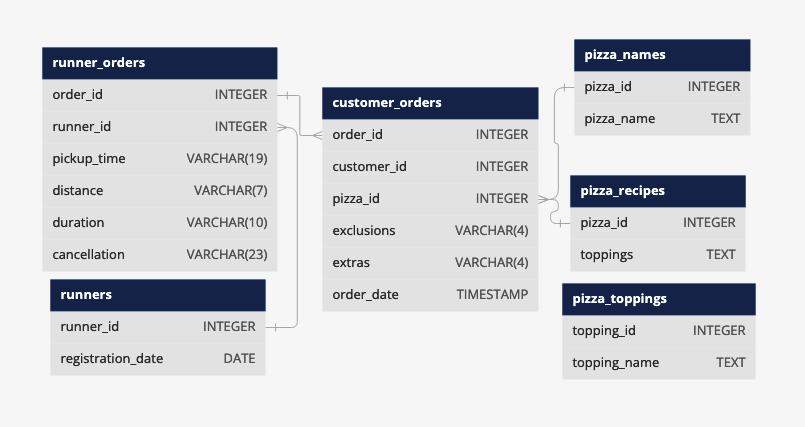

In [13]:
Image(filename='./assets/pizza-runner/pizza-runner-1.png')

# Overview of Tables

## runners

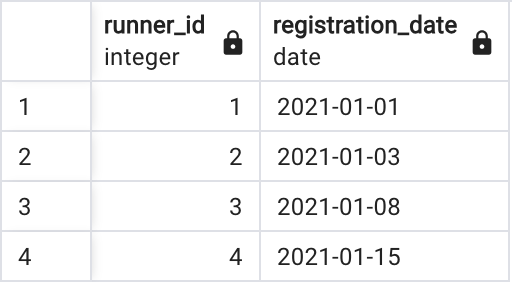

In [4]:
Image(filename='./assets/pizza-runner/pizza-runner-2.png')

## customer_orders

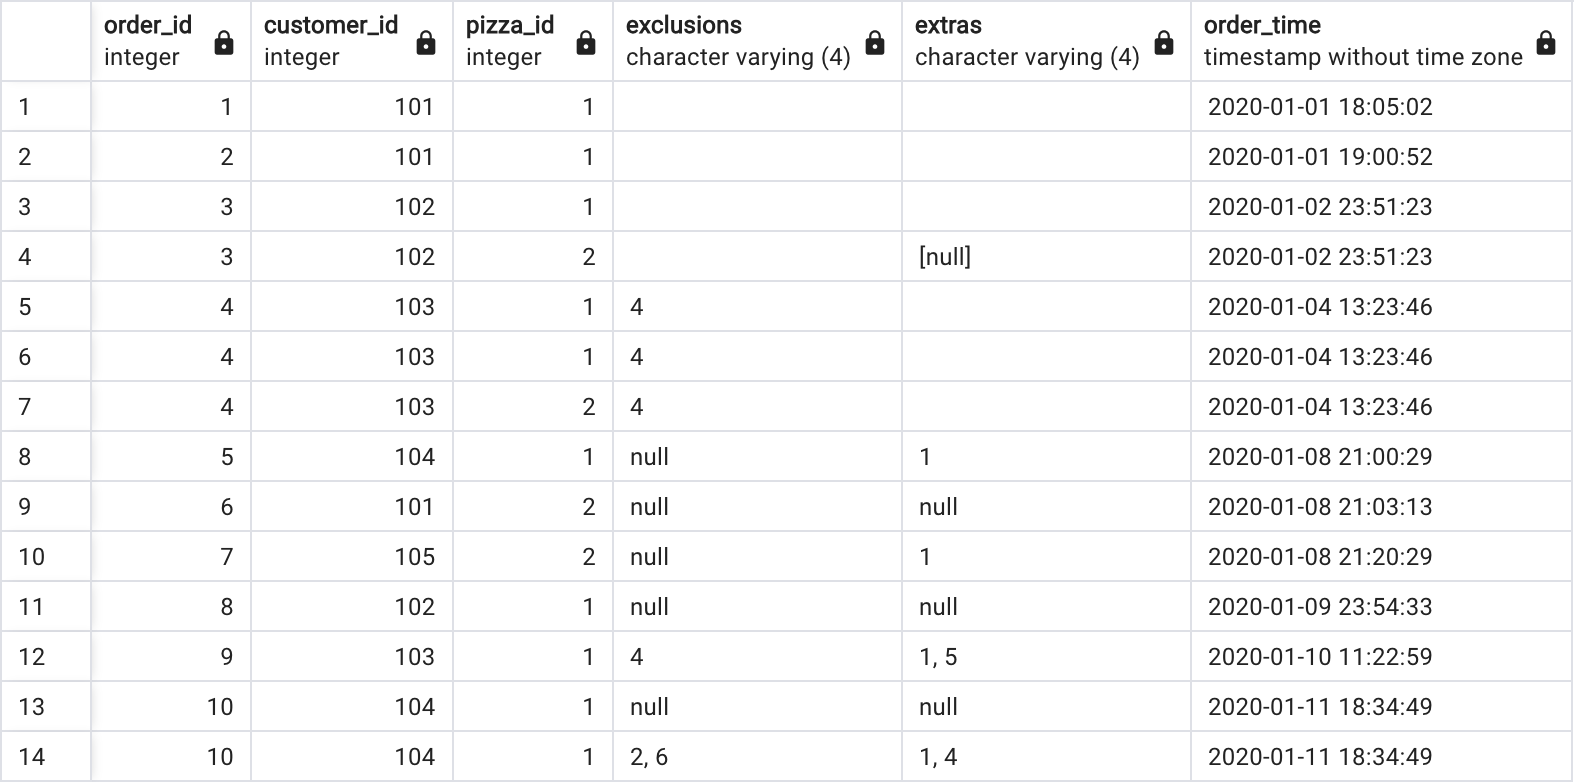

In [5]:
Image(filename='./assets/pizza-runner/pizza-runner-3.png')

## runner_orders

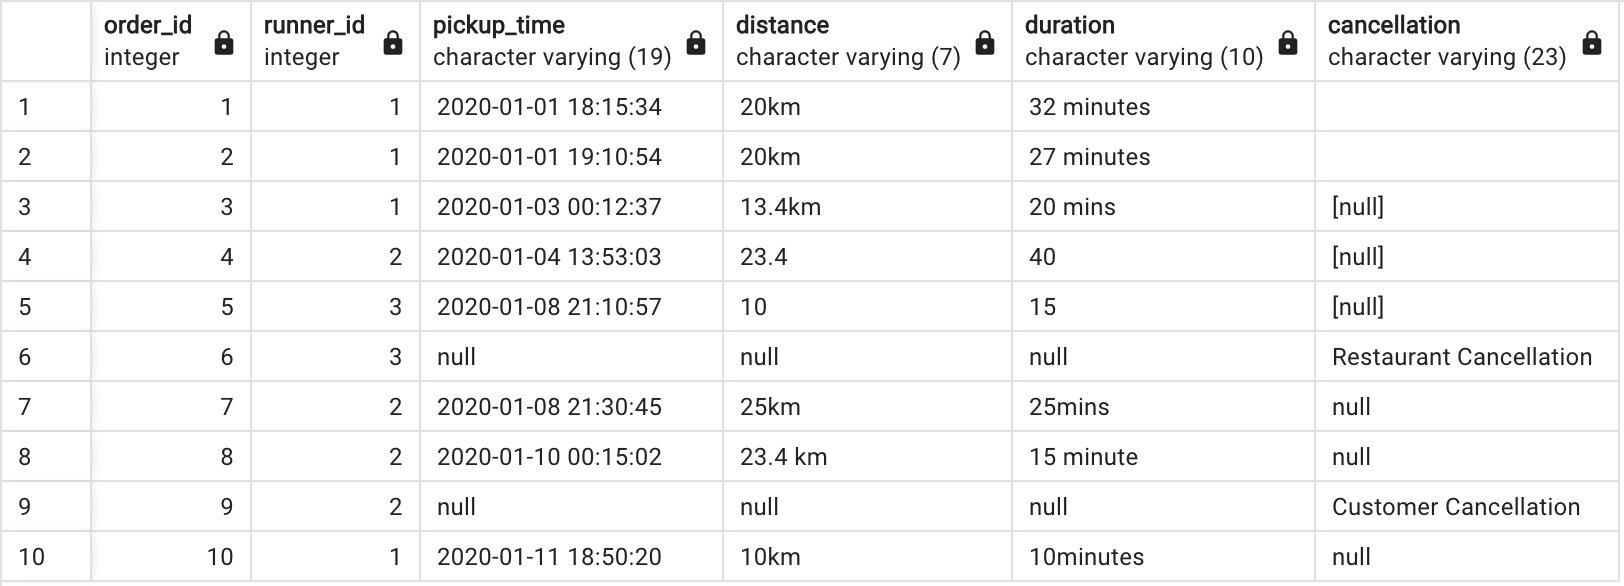

In [6]:
Image(filename='./assets/pizza-runner/pizza-runner-4.png')

## pizza_names

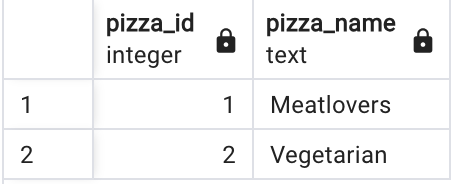

In [7]:
Image(filename='./assets/pizza-runner/pizza-runner-5.png')

## pizza_recipes

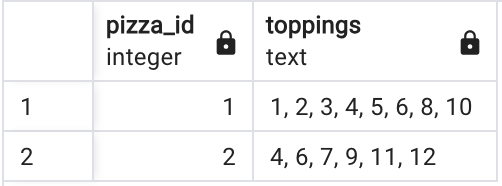

In [8]:
Image(filename='./assets/pizza-runner/pizza-runner-6.png')

## pizza_toppings

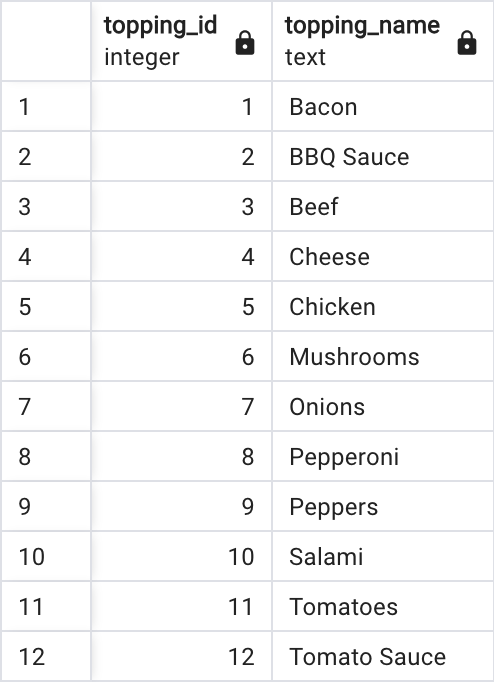

In [12]:
Image(filename='./assets/pizza-runner/pizza-runner-7.png', width=300)

## Observations

```customer_orders``` and ```runner_orders``` tables require data type modifications and cleaning before proceeding with analysis.

customer_orders:
- exclusions ```missing/blank spaces "", null values, wrong data type```
- extras ```missing/blank spaces "", null values, wrong data type```

runner_orders:
- pickup_time ```wrong data type and null values```
- distance ```wrong data type and null values```
- duration ```wrong data type and null values```
- cancellation ```missing/blank spaces "", null values, wrong data type```

# Data Cleaning

## customer_orders

```sql
drop table if exists cleaned_customer_orders;
create temporary table cleaned_customer_orders as
select * from pizza_runner.customer_orders;

update cleaned_customer_orders
set exclusions = null
where cleaned_customer_orders.exclusions = '' or cleaned_customer_orders.exclusions = 'null';

alter table cleaned_customer_orders
alter column exclusions type text;

update cleaned_customer_orders
set extras = null
where cleaned_customer_orders.extras = '' or cleaned_customer_orders.extras = 'null';

alter table cleaned_customer_orders
alter column extras type text;
```

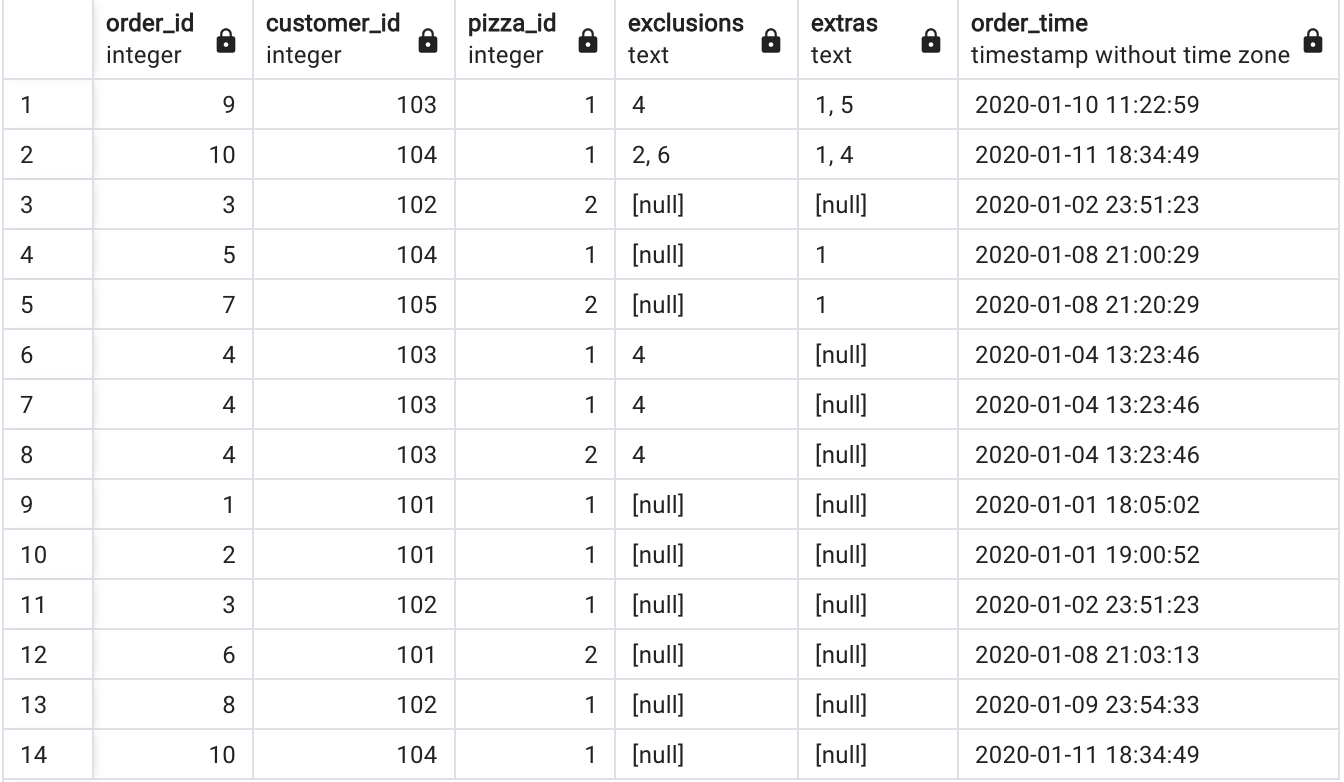

In [15]:
Image(filename='./assets/pizza-runner/pizza-runner-8.png')

## runner_orders

```sql
drop table if exists cleaned_runner_orders;
create temporary table cleaned_runner_orders as
select * from pizza_runner.runner_orders;

update cleaned_runner_orders
set pickup_time = null
where cleaned_runner_orders.pickup_time = 'null';

update cleaned_runner_orders
set distance = null
where cleaned_runner_orders.distance = 'null';

update cleaned_runner_orders
set distance = trim(trailing 'km' from distance);

update cleaned_runner_orders
set duration = (
	select 
		case
			when duration like 'null' then null
			when duration like '%minutes' then trim(trailing 'minutes' from duration)
			when duration like '%mins' then trim(trailing 'mins' from duration)
			when duration like '%minute' then trim(trailing 'minute' from duration)
		end
);

update cleaned_runner_orders
set cancellation = null
where cleaned_runner_orders.cancellation in ('', 'null');

alter table cleaned_runner_orders
alter column pickup_time type timestamp using pickup_time::timestamp without time zone,
alter column distance type float using distance::double precision,
alter column duration type integer using duration::integer,
alter column cancellation type text;
```

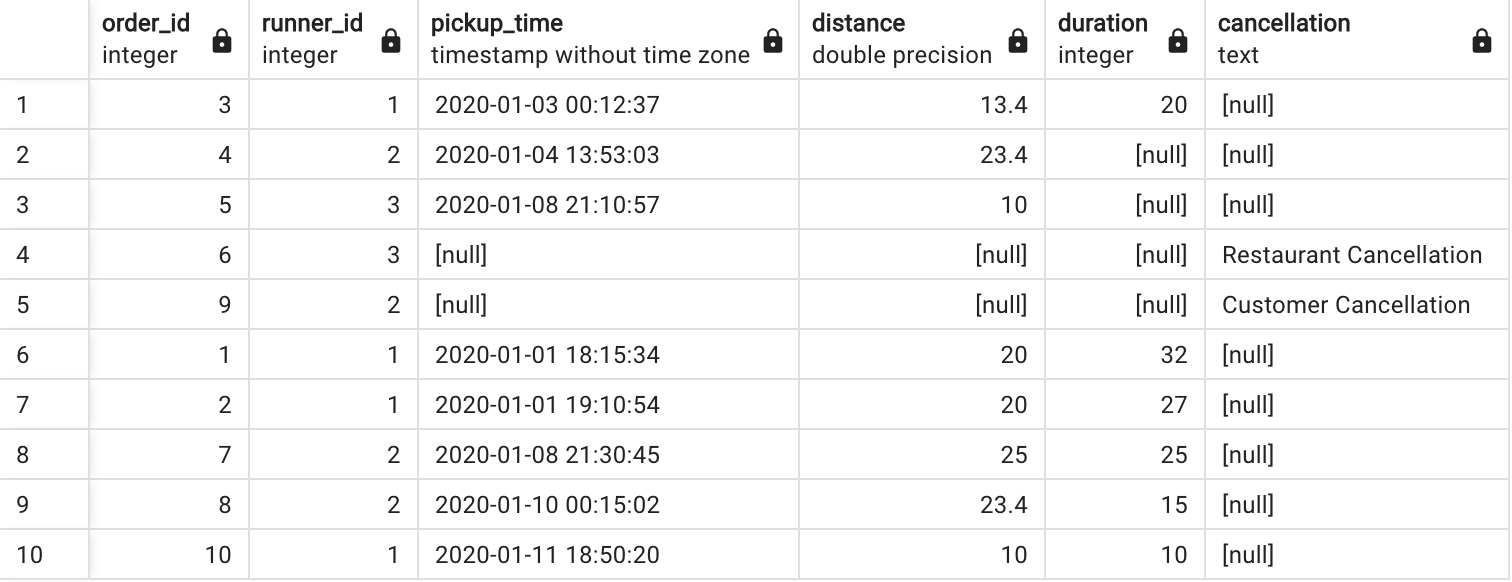

In [16]:
Image(filename='./assets/pizza-runner/pizza-runner-9.png')

# Questions

## Pizza Metrics

***

```1. How many pizzas were ordered?```

```sql
select 
	count(order_id) as "total_orders"
from cleaned_customer_orders;
```

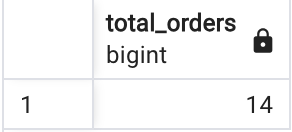

In [17]:
Image(filename='./assets/pizza-runner/pizza-runner-10.png')

**Observations**: Total of 14 pizzas were ordered

***

```2. How many unique customer orders were made?```

```sql
select 
	count(distinct order_id) as "unique_cusotmer_orders" 
from cleaned_customer_orders;
```

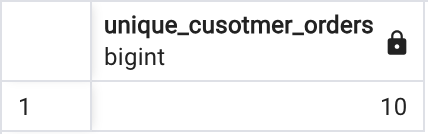

In [18]:
Image(filename='./assets/pizza-runner/pizza-runner-11.png')

**Observations**: Total of 10 unique customer orders were made

***

```3. How many successful orders were delivered by each runner?```

```sql
select 
	runner_id,
	count(order_id) as "successful_orders"
from (
	select 
		order_id,
		runner_id
	from cleaned_runner_orders
	where cancellation is null
) as "subquery"
group by runner_id;
```

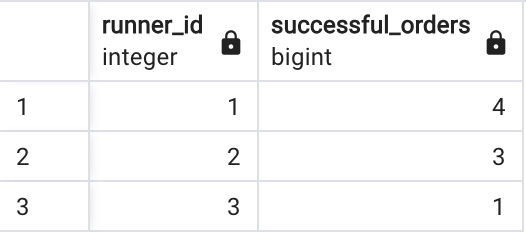

In [19]:
Image(filename='./assets/pizza-runner/pizza-runner-12.png')

***

```4. How many of each type of pizza was delivered?```

```sql
with successful_orders as (
	select 
		order_id,
		pizza_name
	from cleaned_customer_orders
		left join pizza_runner.pizza_names on cleaned_customer_orders.pizza_id = pizza_runner.pizza_names.pizza_id
	where exists (
		select 1
		from cleaned_runner_orders
		where cleaned_customer_orders.order_id = cleaned_runner_orders.order_id and
			  cleaned_runner_orders.cancellation is null
	)
)
select
	pizza_name,
	count(order_id) as "number_delivered"
from successful_orders
group by pizza_name;
```

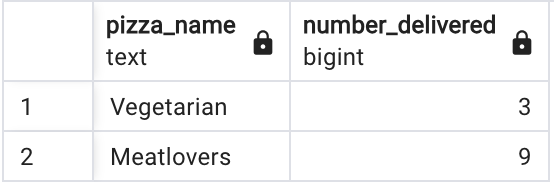

In [20]:
Image(filename='./assets/pizza-runner/pizza-runner-13.png')

**Observations**: 9 Meatlovers and 3 Vegetarian pizzas were successfully delivered

***

```5. How many Vegetarian and Meatlovers were ordered by each customer?```

```sql
select 
	customer_id,
	count(order_id) filter(where pizza_id=1) as "meatlovers",
	count(order_id) filter(where pizza_id=2) as "vegetarian"
from cleaned_customer_orders
group by customer_id
order by customer_id;
```

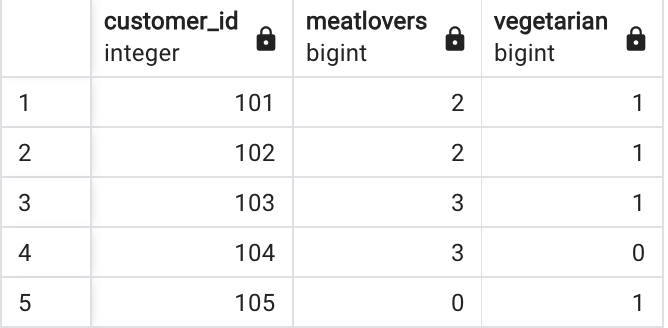

In [22]:
Image(filename='./assets/pizza-runner/pizza-runner-14.png')

***

```6. What was the maximum number of pizzas delivered in a single order?```

```sql
select 
	max(pizza_count) as "max_pizza_count"
from (
	select
		order_id,
		count(*) as "pizza_count"
	from cleaned_customer_orders
	where exists (
		select 1
		from cleaned_runner_orders
		where cleaned_customer_orders.order_id = cleaned_runner_orders.order_id and
			  cleaned_runner_orders.cancellation is null
	)
	group by order_id
) as "subquery"
```

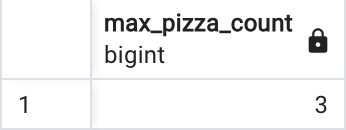

In [23]:
Image(filename='./assets/pizza-runner/pizza-runner-15.png')

***

```7. For each customer, how many delivered pizzas had at least 1 change and how many had no changes?```

```sql
select
	customer_id,
	count(order_id) filter(where exclusions is not null or extras is not null) as "atleast_1_change", 
	count(order_id) filter(where exclusions is null and extras is null) as "no_changes"
from cleaned_customer_orders
where exists (
	select 1
	from cleaned_runner_orders
	where cleaned_customer_orders.order_id = cleaned_runner_orders.order_id and
		  cleaned_runner_orders.cancellation is null
)
group by customer_id
order by customer_id;
```

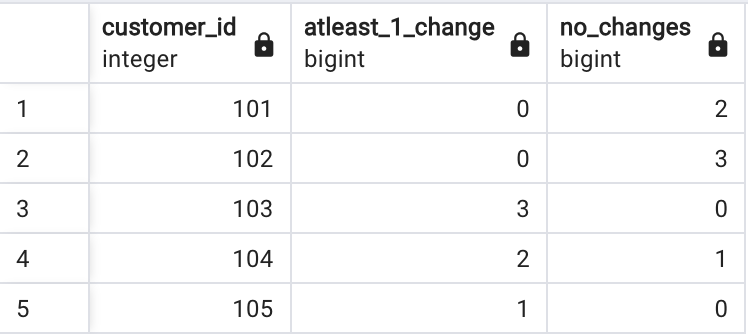

In [24]:
Image(filename='./assets/pizza-runner/pizza-runner-16.png')

**Observations**:
- customer 101 and 102 like the pizzas as per the original recipes
- customers 103,104 and 105 perfer slight changes from the original recipie to suit their taste.

***

```8. How many pizzas were delivered that had both exclusions and extras?```

```sql
select
	count(order_id) filter(where exclusions is not null and extras is not null) as "count"
from cleaned_customer_orders
where exists (
	select 1
	from cleaned_runner_orders
	where cleaned_customer_orders.order_id = cleaned_runner_orders.order_id and
		  cleaned_runner_orders.cancellation is null
);
```

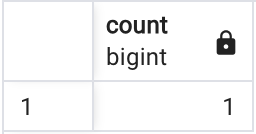

In [25]:
Image(filename='./assets/pizza-runner/pizza-runner-17.png')

**Observations**: only 1 pizza successfully delivered has both exclusion and extra toppings.

***

```9. What was the total volume of pizzas ordered for each hour of the day?```

```sql
select 
	extract('hour' from order_time) as "hour_of_day",
	count(*) as "order_count"
from cleaned_customer_orders
group by 1
order by "order_count" desc, "hour_of_day";
```

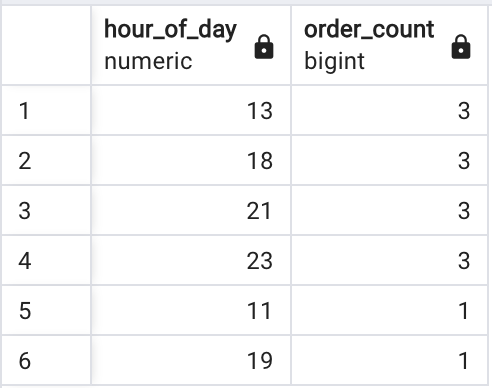

In [26]:
Image(filename='./assets/pizza-runner/pizza-runner-18.png')

**Observations**:
- Highest Volume of orders at 1:00 pm, 6:00 pm, 9:00 pm and 11:00 pm
- Lowest Volume of orders at 11:00 am and 7:00 pm
- Suprising to see a sudden drop in orders at 7:00 pm

***

```10. What was the volume of orders for each day of the week?```

```sql
select 
	to_char(order_time, 'day') as "day_of_week",
	count(*) as "orders"
from cleaned_customer_orders
group by 1, to_char(order_time, 'd')::integer
order by "orders" desc, to_char(order_time, 'd')::integer;
```

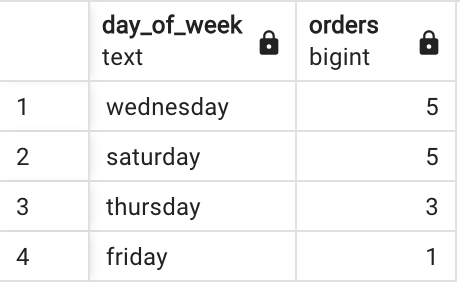

In [27]:
Image(filename='./assets/pizza-runner/pizza-runner-19.png')

**Observations**:
- Wednesday and Saturday have the most amount of orders (5) closely followed by Thursday (3), least amount of orders on Friday (1)

## Runner and Customer Experience

***

```1. How many runners signed up for each 1 week period? (i.e. week starts 2021-01-01)```

In [250]:
query_str = (
    """
    select 
    FLOOR(DATEDIFF(registration_date,'2021-01-01')/7)+1 as registration_week,
    count(*) runner_signup
    from runners
    group by 1
    """
)

In [251]:
execute_query(query_str)

,registration_week,runner_signup
0,1,2
1,2,1
2,3,1


**Observation**: 
- 1st week of JAN 2021 there were 2 new runner signups
- 2nd and 3rd week JAN 2021 there were 1 new runner signups

***

```2. What was the average time in minutes it took for each runner to arrive at the Pizza Runner HQ to pickup the order?```

In [285]:
query_str = (
    """
    select
        r.runner_id,
        ROUND(AVG(TIMESTAMPDIFF(MINUTE, c.order_time,r.pickup_time)),2) as avg_arrival_time
    from 
        customer_orders c
        join
        runner_orders r
        on c.order_id = r.order_id
    where r.pickup_time IS NOT NULL
    group by r.runner_id
    """
)

In [286]:
execute_query(query_str)

,runner_id,avg_arrival_time
0,1,15.33
1,2,23.40
2,3,10.00


**Observations**:
- runner 3 has the fastest average arrival time at 10 minutes
- runner 1 has the 2nd fastest average arrival time at around 15 minutes
- runner 2 has a comparatively high average arrival time at 23 minutes 

***

```3. Is there any relationship between the number of pizzas and how long the order takes to prepare?```

In [62]:
query_str = (
    """
    with prep_time as (
        select
            c.order_id,
            count(*) as number_of_pizzas,
            AVG(TIMESTAMPDIFF(MINUTE, c.order_time, r.pickup_time)) as preparation_time
        from
            customer_orders c
            join
            runner_orders r
            on c.order_id = r.order_id
        where r.pickup_time is not null
        group by c.order_id
    )

    select
        number_of_pizzas,
        AVG(preparation_time) as avg_prep_time
    from prep_time
    group by number_of_pizzas
    """
)

In [63]:
execute_query(query_str)

,number_of_pizzas,avg_prep_time
0,1,12.0
1,2,18.0
2,3,29.0


**Observations**: From the above table we see a direct relationship between the number of pizzas per order and the prep time.

***

```4. What was the average distance travelled for each customer?```

In [10]:
query_str = (
    """
    select 
        c.customer_id,
        ROUND(AVG(r.distance),2) as avg_distance
    from 
        customer_orders c 
        join
        runner_orders r
        on c.order_id = r.order_id
    where r.duration is not null
    group by c.customer_id
    """
)

In [11]:
execute_query(query_str)

,customer_id,avg_distance
0,101,20.00
1,102,16.73
2,103,23.40
3,104,10.00
4,105,25.00


***

```5. What was the difference between the longest and shortest delivery times for all orders?```

In [16]:
query_str = (
    """
    select 
        MAX(duration) - MIN(duration) as difference
    from runner_orders
    where duration is not null
    """
)

In [17]:
execute_query(query_str)

,difference
0,30


***

```6. What was the average speed for each runner for each delivery and do you notice any trend for these values?```

In [24]:
query_str = (
    """
    select 
        order_id,
        runner_id,
        ROUND(distance / (duration/60),2) as avg_speed_kmh
    from 
        runner_orders r
    where r.duration is not null
    order by 3 asc
    """
)

In [25]:
execute_query(query_str)

,order_id,runner_id,avg_speed_kmh
0,4,2,35.10
1,1,1,37.50
2,5,3,40.00
3,3,1,40.20
4,2,1,44.44
5,7,2,60.00
6,10,1,60.00
7,8,2,93.60


***

```7. What is the successful delivery percentage for each runner?```

In [34]:
query_str = (
    """
    select 
        runner_id,
        (1 - (COUNT(cancellation)/COUNT(*))) * 100 as successful_delivery_pct
    from 
        runner_orders r
    group by  runner_id
    """
)

In [35]:
execute_query(query_str)

,runner_id,successful_delivery_pct
0,1,100.0
1,2,75.0
2,3,50.0


**Observations**: note that the low successful_delivery_pct is due to order cancellation by the restaurant or the customer with is not in the hands of the runner. A different metric should be used to gauge the effectiveness of a runner.

## Ingredient Optimisation

**REVISIT AFTER MORE EXPERIENCE WITH HANDLING STRINGS (6 questions)**

## Pricing and Ratings

***

```1. If a Meat Lovers pizza costs $12 and Vegetarian costs $10 and there were no charges for changes - how much money has Pizza Runner made so far if there are no delivery fees?```

In [47]:
query_str = (
    """
    select 
        SUM(
            CASE
                when pizza_name like "meatlovers" then 12
                else 10
            END
        ) as total_revenue
    from 
        customer_orders c
        join
        runner_orders r
        on c.order_id = r.order_id
        join
        pizza_names p
        on p.pizza_id = c.pizza_id
    where duration is not null
    """
)

In [48]:
execute_query(query_str)

,total_revenue
0,138.0


***

```5. If a Meat Lovers pizza was $12 and Vegetarian $10 fixed prices with no cost for extras and each runner is paid $0.30 per kilometre traveled - how much money does Pizza Runner have left over after these deliveries?```

In [54]:
execute_query(
    """
    with costs_cte as (
        select 
            CASE
                when pizza_name like "meatlovers" then 12
                else 10
            END as revenue,
            distance * 0.30 as runner_charges
        from 
            customer_orders c
            join
            runner_orders r
            on c.order_id = r.order_id
            join
            pizza_names p
            on p.pizza_id = c.pizza_id
        where duration is not null
    )

    select 
        ROUND(SUM(revenue - runner_charges),2)
    from costs_cte
    """
)

,"ROUND(SUM(revenue - runner_charges),2)"
0,73.38


**Suggestions**: Pizza runner should charge for extras or apply a delivery fee to compensate for the runner_charges and other expenses in the future

**REVISIT AFTER MORE EXPERIENCE (3 questions)**